In [119]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import DataPreprocessing as spike_process
import random as random



In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
        
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[31]
print(dat.keys())

print(alldat[31]['mouse_name'])
print(alldat[31]['date_exp'])

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])
Richards
2017-10-31


In [3]:
# Getting spike data using codes from NMA
# Adapted from https://github.com/MouseLand/steinmetz2019_NMA/blob/master/steinmetz_loader.py

dT = 2.5
T0 = .5
bin_size = 20
dt = bin_size/1000

#data_path = '/Users/ChiaXinWei/Documents/Connected_lizards/Steinmetz/Richards_2017-10-31'
data_path = '/Users/xinweichia/Documents/connected_lizards/Steinmetz_dataset/Richards_2017-10-31'

def get_event_times(fdirpath):
    response_times = np.load(os.path.join(fdirpath, "trials.response_times.npy"))
    visual_times = np.load(os.path.join(fdirpath,   "trials.visualStim_times.npy"))
    gocue = np.load(os.path.join(fdirpath,   "trials.goCue_times.npy"))
    feedback = np.load(os.path.join(fdirpath,   "trials.feedback_times.npy"))

    rsp = response_times - visual_times
    feedback = feedback - visual_times
    gocue = gocue - visual_times

    return response_times, visual_times, rsp, gocue, feedback

def get_good_cells(fdirpath):
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

def get_spikes(fdirpath):
    stimes = np.load(os.path.join(fdirpath, "spikes.times.npy")).flatten()
    sclust = np.load(os.path.join(fdirpath, "spikes.clusters.npy")).flatten()
    return stimes, sclust

def psth(stimes, sclust, etime, dT, dt):
    NN = np.max(sclust)+1
    NT = int(dT/dt)
    ntrials = len(etime)

    S  = np.zeros((NN, ntrials, NT))
    for j in range(ntrials):
        k1   = first_spikes(stimes, etime[j])
        k2   = first_spikes(stimes, etime[j]+dT)
        st   = stimes[k1:k2] - etime[j]
        clu  = sclust[k1:k2]
        S[:,j,:] = csr_matrix((np.ones(k2-k1), (clu, np.int32(st/dt))), shape=(NN,NT)).todense()

    return S
def first_spikes(stimes, t0):
    tlow = 0
    thigh = len(stimes)

    while thigh>tlow+1:
        thalf = (thigh + tlow)//2
        sthalf = stimes[thalf]
        if t0 >= sthalf:
            tlow = thalf
        else:
            thigh = thalf
    return thigh

good_cells, brain_region, br = get_good_cells(data_path)
response_times, visual_times, rsp, gocue, feedback = get_event_times(data_path)
    
stimes, sclust = get_spikes(data_path)
S  = psth(stimes, sclust,   visual_times-T0, dT, dt)
#good_cells = good_cells * (np.mean(S, axis=(1,2))>0)
S  = S[good_cells].astype('int8') 

ntrials = len(visual_times-T0)
NMA_spikes = S[:, :ntrials, :]

print('Total number of cells',NMA_spikes.shape)
print('Total number of trials',NMA_spikes[1].shape)
print('Trial trial duration in bins',NMA_spikes[1][1].shape)

NMA_binned_trial_data = NMA_spikes
# Reformat the pre-processed data from NMA for our own use.
reformated_NMA_binned_trial_data = np.empty(len(NMA_binned_trial_data), dtype=object) # Number of cells
for cell_num in np.arange(len(NMA_binned_trial_data)):
    reformated_NMA_binned_trial_data[cell_num] = np.empty(len(NMA_binned_trial_data[cell_num]), dtype=object) # Number of trials
    
    for trial_num in np.arange(len(NMA_binned_trial_data[cell_num])):
        reformated_NMA_binned_trial_data[cell_num][trial_num] = NMA_binned_trial_data[cell_num][trial_num]
        
# reformated_NMA_binned_trial_data[1][1]

Total number of cells (522, 260, 125)
Total number of trials (260, 125)
Trial trial duration in bins (125,)


In [4]:
# Load desired data from 1 session 1 animal
# Note that there are 340 trials in 1 session
# (For more info https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files)


trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy') 
trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
site_positions = np.load(data_path+'/'+'channels.sitePositions.npy')
clusters_depths = np.load(data_path+'/'+'clusters.depths.npy')
clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
channel_sites = np.load(data_path+'/'+'channels.site.npy')
channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
channels_probe = np.load(data_path+'/'+'channels.probe.npy')
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
trial_feedback_time = np.load(data_path+'/'+'trials.feedback_times.npy')
trial_feedback_type = np.load(data_path+'/'+'trials.feedbackType.npy')
trial_response_time = np.load(data_path+'/'+'trials.response_times.npy')

visual_times = trials_visual_time
# Behaviour data

wheel_movement = np.load(data_path+'/'+'wheelMoves.type.npy')
wheel_intervals = np.load(data_path+'/'+'wheelMoves.intervals.npy')


In [5]:
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

# Get neural activity data
good_cells, brain_regions ,br = spike_process.get_good_cells(data_path) # Get brain regions

# Used reformated processed spike data taken from https://github.com/MouseLand/steinmetz2019_NMA/blob/master/steinmetz_NMA.ipynb
pre_stim_spike_time_binned_trial, post_stim_spike_time_binned_trial, post_go_cue_spike_time_binned_trial, post_reward_spike_time_binned_trial = spike_process.NMA_sort_cells_behaviour_trials(reformated_NMA_binned_trial_data ,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size)

# Sort cells into left, right and no_response trial types
# Input behaviour phase that you want to analyse
input_spike_behaviour_period = post_stim_spike_time_binned_trial
left_spike_time_response, right_spike_time_response, no_response_spike_time_response = spike_process.sort_cells_trial_types(input_spike_behaviour_period,trials_intervals,trials_response_choice)

# Midbrain cells
midbrain_right_spike = spike_process.updated_sort_cells_brain_regions(right_spike_time_response, brain_regions, clusters_annotation, mid_brain_circuits)
midbrain_concat_right_spike_times = spike_process.concat_trials_2_timeseries(midbrain_right_spike)

# Forebrain cells
forebrain_right_spike = spike_process.updated_sort_cells_brain_regions(right_spike_time_response, brain_regions, clusters_annotation, frontal_circuits)
forebrain_concat_right_spike_times = spike_process.concat_trials_2_timeseries(forebrain_right_spike)

# MOs cells
input_region = ['MOs']
mos_right_spike = spike_process.updated_sort_cells_brain_regions(right_spike_time_response, brain_regions, clusters_annotation, input_region)
mos_concat_right_spike_times = spike_process.concat_trials_2_timeseries(midbrain_right_spike)

# SCm cells
input_region = ['SCm']
scm_right_spike = spike_process.updated_sort_cells_brain_regions(right_spike_time_response, brain_regions, clusters_annotation, input_region)
scm_concat_right_spike_times = spike_process.concat_trials_2_timeseries(midbrain_right_spike)


    
    

In [179]:
print(scm_concat_right_spike_times[1].shape)
print(mos_concat_right_spike_times[2].shape)

(2248,)
(2248,)


In [196]:
# Sort spike data into training and test data set

def sort_train_test_set(spike_data, training_ratio = 0.66):
    train_idx = random.sample(range(len(spike_data[0])), (int(len(spike_data[0])*training_ratio )) )
    test_idx = np.setxor1d(train_idx,  range(len(spike_data[0])))
    
    train_spike_data = np.empty(len(spike_data), dtype=object)
    test_spike_data = np.empty(len(spike_data), dtype=object)
    for cell_num in np.arange(len(spike_data)):
        train_spike_data[cell_num] = spike_data[cell_num][train_idx] 
        test_spike_data[cell_num] = spike_data[cell_num][test_idx] 
        
    return train_spike_data, test_spike_data

random.seed(1)
train_scm_right_spike, test_scm_right_spike = sort_train_test_set(scm_right_spike, training_ratio = 0.66)
random.seed(1)
train_mos_right_spike, test_mos_right_spike = sort_train_test_set(mos_right_spike, training_ratio = 0.66)

# Concatenate it back into time series
train_scm_right_spike = spike_process.concat_trials_2_timeseries(train_scm_right_spike)
test_scm_right_spike = spike_process.concat_trials_2_timeseries(test_scm_right_spike)
train_mos_right_spike = spike_process.concat_trials_2_timeseries(train_mos_right_spike)
test_mos_right_spike = spike_process.concat_trials_2_timeseries(test_mos_right_spike)

print('train mos', train_mos_right_spike[1].shape)
print('train scm', train_scm_right_spike[1].shape)

print('test mos', test_mos_right_spike[1].shape)
print('test scm', test_scm_right_spike[1].shape)



train mos (1450,)
train scm (1450,)
test mos (798,)
test scm (798,)


(260, 250)
(260, 250)
Number of wheel time bins in right trials:  (2248,)
Number of face time bins in right trials:  (2248,)
Number of pupil time bins in right trials:  (2248,)
Number of lick time bins in right trials:  (2248,)
# of bins in the entire time series:  [2248.]
Number of concat bins in right trials (spike data):  (2248,)
Number of right trials:  [75]
(260, 250)
(260, 250)
Number of wheel time bins in right trials:  (2248,)
Number of face time bins in right trials:  (2248,)
Number of pupil time bins in right trials:  (2248,)
Number of lick time bins in right trials:  (2248,)
# of bins in the entire time series:  [2248.]
Number of concat bins in right trials (spike data):  (2248,)
Number of right trials:  [75]


<function matplotlib.pyplot.show(*args, **kw)>

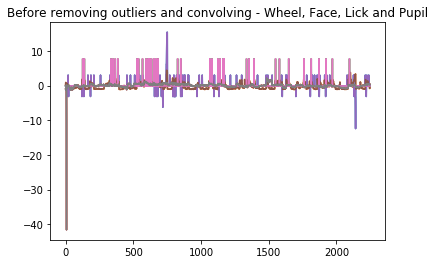

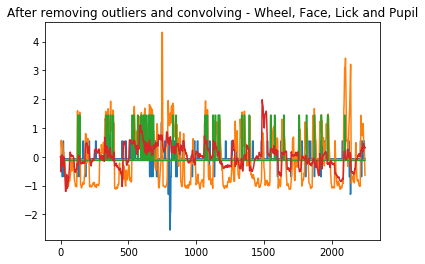

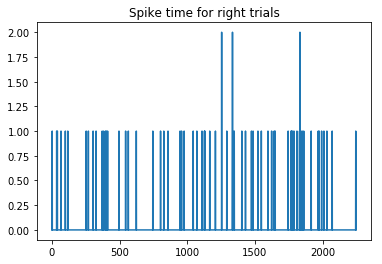

In [7]:
# Get behaviour data from https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb#scrollTo=yGho9_kaEDGc
#left_concat_wheel_position, right_concat_wheel_position, no_response_concat_wheel_position = spike_process.concat_behaviour_2_timeseries(wheel_position, trials_response_choice,epoch_duration = 500 ,bin_size = 10)

def concat_behaviour_2_timeseries(beh_data,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size ):
    # Get response choice trials types
    right_choice_trials = np.where(trials_response_choice == -1)[0]
    #left_choice_trials = np.where(trials_response_choice == 1)[0]
    #no_response_choice_trials = np.where(trials_response_choice == 0)[0]
    
    # Left trials
    pre_stim_right_concat_beh_data = np.array([])
    post_stim_right_concat_beh_data = np.array([])
    post_go_cue_right_concat_beh_data = np.array([])
    post_reward_right_concat_beh_data = np.array([])

    for i in right_choice_trials:
        time_zero = 0
        visual_time = int( T0 *1000/bin_size)
        gocue_time = int( (trials_gocue_times[i] - trials_visual_time[i]) * 1000/bin_size + visual_time)
        feedback_time = int( (trial_feedback_time[i] - trials_gocue_times[i]) * 1000/bin_size + gocue_time)
        
        # Post-stim epoch (Visual Stim : Go Cue)
        pre_stim_right_concat_beh_data = np.append(pre_stim_right_concat_beh_data, beh_data[i][0:int(T0*1000/bin_size)])
        # Post-stim epoch (Visual Stim : Go Cue)
        post_stim_right_concat_beh_data = np.append(post_stim_right_concat_beh_data, beh_data[i][visual_time:gocue_time])
        # Post-gocue epoch (Gocue : Reward) Very short duration
        post_go_cue_right_concat_beh_data = np.append(post_go_cue_right_concat_beh_data, beh_data[i][gocue_time: feedback_time ])
        # Post-reward epoch (Reward : Reward + 500ms)
        post_reward_right_concat_beh_data  = np.append(post_reward_right_concat_beh_data, beh_data[i][feedback_time: feedback_time+int(T0*1000/bin_size)])
    
    # Perform Zscore on concatenated behavioural output
    return stats.zscore(pre_stim_right_concat_beh_data), stats.zscore(post_stim_right_concat_beh_data), stats.zscore(post_go_cue_right_concat_beh_data), stats.zscore(post_reward_right_concat_beh_data)


data_wheel = (dat['wheel'][0,:,:])
data_face = (dat['face'][0,:,:])
data_pupil = (dat['pupil'][0,:,:])
data_lick = (dat['licks'][0,:,:])

# Note that zscoring has already been done.
wheel_pre_stim_right_concat_beh_data, wheel_post_stim_right_concat_beh_data, wheel_post_go_cue_right_concat_beh_data, wheel_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_wheel,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )
face_pre_stim_right_concat_beh_data, face_post_stim_right_concat_beh_data, face_post_go_cue_right_concat_beh_data, face_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_face,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )
pupil_pre_stim_right_concat_beh_data, pupil_post_stim_right_concat_beh_data, pupil_post_go_cue_right_concat_beh_data, pupil_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_pupil,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )
lick_pre_stim_right_concat_beh_data, lick_post_stim_right_concat_beh_data, lick_post_go_cue_right_concat_beh_data, lick_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_lick,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )

print(data_wheel.shape)
print(data_face.shape)

# Making sure that number of bins in behaviour data tallies with # activity bins
total_trial_duration = np.zeros((len(right_spike_time_response[1]),1))
for i in np.arange(len(right_spike_time_response[1])):
    total_trial_duration[i] = len(right_spike_time_response[1][i])
    
print('Number of wheel time bins in right trials: ', wheel_post_stim_right_concat_beh_data.shape)
print('Number of face time bins in right trials: ', face_post_stim_right_concat_beh_data.shape)
print('Number of pupil time bins in right trials: ', pupil_post_stim_right_concat_beh_data.shape)
print('Number of lick time bins in right trials: ', lick_post_stim_right_concat_beh_data.shape)

print('# of bins in the entire time series: ', sum(total_trial_duration))
print('Number of concat bins in right trials (spike data): ',spike_process.concat_trials_2_timeseries(right_spike_time_response)[1].shape)

print('Number of right trials: ',sum(trials_response_choice == -1))

def reject_outliers(data, m=5):
    outlier_idx = np.where(abs(data- np.mean(data)) > m * np.std(data))
    data[outlier_idx] = 0
    return data

plt.figure(0)
plt.plot(wheel_post_stim_right_concat_beh_data)
plt.title('Before removing outliers and convolving - Wheel, Face, Lick and Pupil')
plt.plot(face_post_stim_right_concat_beh_data)
plt.plot(lick_post_stim_right_concat_beh_data)
plt.plot(pupil_post_stim_right_concat_beh_data)
plt.show

wheel_post_stim_right_concat_beh_data = reject_outliers(wheel_post_stim_right_concat_beh_data, m=5)
face_post_stim_right_concat_beh_data = reject_outliers(face_post_stim_right_concat_beh_data, m=5)
pupil_post_stim_right_concat_beh_data = reject_outliers(pupil_post_stim_right_concat_beh_data, m=5)
#lick_post_stim_right_concat_beh_data = reject_outliers(lick_post_stim_right_concat_beh_data, m=1)

window = 5 # Moving average window size
ma_wheel_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(wheel_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))
ma_face_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(face_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))
ma_pupil_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(pupil_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))
ma_lick_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(lick_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))


data_wheel = (dat['wheel'][0,:,:])
data_face = (dat['face'][0,:,:])
data_pupil = (dat['pupil'][0,:,:])
data_lick = (dat['licks'][0,:,:])

# Note that zscoring has already been done.
wheel_pre_stim_right_concat_beh_data, wheel_post_stim_right_concat_beh_data, wheel_post_go_cue_right_concat_beh_data, wheel_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_wheel,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )
face_pre_stim_right_concat_beh_data, face_post_stim_right_concat_beh_data, face_post_go_cue_right_concat_beh_data, face_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_face,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )
pupil_pre_stim_right_concat_beh_data, pupil_post_stim_right_concat_beh_data, pupil_post_go_cue_right_concat_beh_data, pupil_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_pupil,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )
lick_pre_stim_right_concat_beh_data, lick_post_stim_right_concat_beh_data, lick_post_go_cue_right_concat_beh_data, lick_post_reward_right_concat_beh_data = concat_behaviour_2_timeseries(data_lick,trials_response_choice,trials_visual_time,trials_gocue_times,trial_feedback_time,bin_size )

print(data_wheel.shape)
print(data_face.shape)

# Making sure that number of bins in behaviour data tallies with # activity bins
total_trial_duration = np.zeros((len(right_spike_time_response[1]),1))
for i in np.arange(len(right_spike_time_response[1])):
    total_trial_duration[i] = len(right_spike_time_response[1][i])
    
print('Number of wheel time bins in right trials: ', wheel_post_stim_right_concat_beh_data.shape)
print('Number of face time bins in right trials: ', face_post_stim_right_concat_beh_data.shape)
print('Number of pupil time bins in right trials: ', pupil_post_stim_right_concat_beh_data.shape)
print('Number of lick time bins in right trials: ', lick_post_stim_right_concat_beh_data.shape)

print('# of bins in the entire time series: ', sum(total_trial_duration))
print('Number of concat bins in right trials (spike data): ',spike_process.concat_trials_2_timeseries(right_spike_time_response)[1].shape)

print('Number of right trials: ',sum(trials_response_choice == -1))

def reject_outliers(data, m=5):
    outlier_idx = np.where(abs(data- np.mean(data)) > m * np.std(data))
    data[outlier_idx] = 0
    return data

plt.figure(0)
plt.plot(wheel_post_stim_right_concat_beh_data)
plt.title('Before removing outliers and convolving - Wheel, Face, Lick and Pupil')
plt.plot(face_post_stim_right_concat_beh_data)
plt.plot(lick_post_stim_right_concat_beh_data)
plt.plot(pupil_post_stim_right_concat_beh_data)
plt.show

wheel_post_stim_right_concat_beh_data = reject_outliers(wheel_post_stim_right_concat_beh_data, m=5)
face_post_stim_right_concat_beh_data = reject_outliers(face_post_stim_right_concat_beh_data, m=5)
pupil_post_stim_right_concat_beh_data = reject_outliers(pupil_post_stim_right_concat_beh_data, m=5)
#lick_post_stim_right_concat_beh_data = reject_outliers(lick_post_stim_right_concat_beh_data, m=1)

window = 5 # Moving average window size
ma_wheel_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(wheel_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))
ma_face_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(face_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))
ma_pupil_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(pupil_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))
ma_lick_post_stim_right_concat_beh_data = np.append(np.zeros((window-1,1)),np.convolve(lick_post_stim_right_concat_beh_data, np.ones((window,))/window, mode='valid'))


plt.figure(1)
plt.plot(ma_wheel_post_stim_right_concat_beh_data)
plt.title('After removing outliers and convolving - Wheel, Face, Lick and Pupil')
plt.plot(ma_face_post_stim_right_concat_beh_data)
plt.plot(ma_lick_post_stim_right_concat_beh_data)
plt.plot(ma_pupil_post_stim_right_concat_beh_data)
plt.show

plt.figure(2)
plt.plot(midbrain_concat_right_spike_times[10])
plt.title('Spike time for right trials')
plt.show

In [116]:
# Variables to use
'''
1. Predicted activity: mos_concat_right_spike_times
    Training and test data
2. Predictor activity: scm_concat_right_spike_times
    Training and test data

3. Behaviour activity 
    Training and test data
'''

'\n1. Predicted activity: mos_concat_right_spike_times\n    Training and test data\n2. Predictor activity: scm_concat_right_spike_times\n    Training and test data\n\n3. Behaviour activity \n    Training and test data\n'

## PCA of data to reduce dimensions

In [247]:
# Adjusting data for PCA dim reduction. i.e. creating matrix
def matrix_reformat(spike_data):
    matrix = np.zeros((len(spike_data),len(spike_data[0])))
    for cell_num in np.arange(len(spike_data)):
        matrix[cell_num,:] = spike_data[cell_num]
    return matrix.T

train_matrix_mos_right_spike  = matrix_reformat(train_mos_right_spike)
train_matrix_scm_right_spike  = matrix_reformat(train_scm_right_spike)
test_matrix_mos_right_spike  = matrix_reformat(test_mos_right_spike)
test_matrix_scm_right_spike  = matrix_reformat(test_scm_right_spike)

print('Shape of all cell matrix (bins x cells): ', train_matrix_mos_right_spike.shape)

predictor_num_components = 10
predicted_num_components = 5
pca_predictor = PCA(predictor_num_components)
pca_predicted = PCA(predicted_num_components)
train_mos_components = pca_predictor.fit_transform(train_matrix_mos_right_spike)
train_scm_components = pca_predicted.fit_transform(train_matrix_scm_right_spike)

test_mos_components = pca_predictor.transform(test_matrix_mos_right_spike)
test_scm_components = pca_predicted.transform(test_matrix_scm_right_spike)

print('Dimensions of train predictor matrix (bins x dimen): ',train_mos_components.shape)
print('Dimensions of train predicted matrix (bins x dimen): ',train_scm_components.shape)
print('Dimensions of test predictor matrix (bins x dimen): ',test_mos_components.shape)
print('Dimensions of test predicted matrix (bins x dimen): ',test_scm_components.shape)



Shape of all cell matrix (bins x cells):  (1450, 69)
Dimensions of train predictor matrix (bins x dimen):  (1450, 10)
Dimensions of train predicted matrix (bins x dimen):  (1450, 5)
Dimensions of test predictor matrix (bins x dimen):  (798, 10)
Dimensions of test predicted matrix (bins x dimen):  (798, 5)


Shape of predicted activity:  (1450, 5)
Shape of cor coeff:  (5, 10)


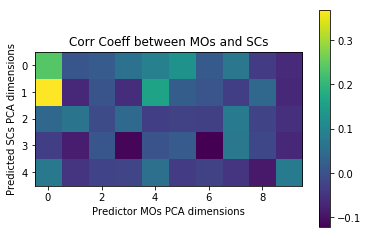

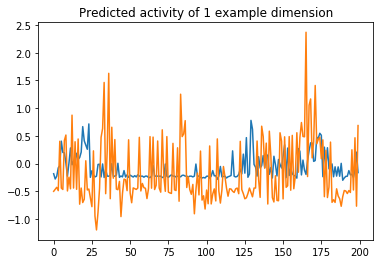

In [248]:
from sklearn.linear_model import Ridge

# Perform multiple linear regression on matrices
mod = Ridge()
mod.fit(train_mos_components,train_scm_components)

# Get predicted activity
y_hat = mod.predict(train_mos_components)
activity_coeff = mod.coef_
print('Shape of predicted activity: ', y_hat.shape)

plt.figure(1)
plt.imshow(activity_coeff)
plt.title('Corr Coeff between MOs and SCs')
plt.xlabel('Predictor MOs PCA dimensions')
plt.ylabel('Predicted SCs PCA dimensions')
plt.colorbar()
plt.show

plt.figure(0)
plt.plot(y_hat[0:200,1])
plt.plot(test_mos_components[0:200,1])
plt.title('Predicted activity of 1 example dimension')
plt.show

print('Shape of cor coeff: ', activity_coeff.shape)

In [139]:
def matrix_reformat(spike_data):
    matrix = np.zeros((len(spike_data),len(spike_data[0])))
    for cell_num in np.arange(len(spike_data)):
        matrix[cell_num,:] = spike_data[cell_num]
        
    return matrix

matrix_reformat(spike_data)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])